# MNIST Adversarial Detector with Kfserving

![demo](demo.png)

Prequisites:

 * Running cluster with kfserving installed and authenticated for use with `kubectl`
    * Istio with Istio Gateway exposed on a LoadBalancer
 * Knative eventing installed
 * Download the MNIST model: run `make model_mnist` (Requires `gsutils`)
 * Pip install the alibi-detect library.

## Setup Resources

Enabled eventing on default namespace. This will activate a default Knative Broker.

In [ ]:
!kubectl label namespace default knative-eventing-injection=enabled

Create a Knative service to dump events it receives. This will be the example final sink for adversarial events.

In [ ]:
!pygmentize message-dumper.yaml

In [ ]:
!kubectl apply -f message-dumper.yaml

Create the Kfserving image classification model for MNIST. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [ ]:
!pygmentize mnist.yaml

In [ ]:
!kubectl apply -f mnist.yaml

Create the pretrained MNIST Adversarial detector. We forward replies to the message-dumper we started.

In [ ]:
!pygmentize mnistad.yaml

In [ ]:
!kubectl apply -f mnistad.yaml

Create a Knative trigger to forward logging events to our Adversarial Detector.

In [ ]:
!pygmentize trigger.yaml

In [ ]:
!kubectl apply -f trigger.yaml

Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [3]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

35.204.250.26


In [4]:
SERVICE_HOSTNAMES=!(kubectl get inferenceservice mnist -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_MNIST=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_MNIST)

mnist.default.example.com


In [5]:
SERVICE_HOSTNAMES=!(kubectl get ksvc ad-mnist -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_MNISTAD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_MNISTAD)

ad-mnist.default.example.com


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.keras.backend.clear_session()

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import requests

train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
img_shape = (28, 28)

def show(X):
    plt.imshow(X.reshape(img_shape))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_MNIST
    res = requests.post('http://'+CLUSTER_IP+'/v1/models/mnist:predict', json=formData, headers=headers)
    if res.status_code == 200:
        return np.array(res.json()["predictions"])
    else:
        print("Failed with ",res.status_code)
        return []
    
def detect(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {"alibi-detect-return-instance-score":"true"}
    headers["Host"] = SERVICE_HOSTNAME_MNISTAD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        ad = res.json()
        ad["data"]["instance_score"] = np.array(ad["data"]["instance_score"])
        return ad
    else:
        print("Failed with ",res.status_code)
        return []

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Normal Prediction

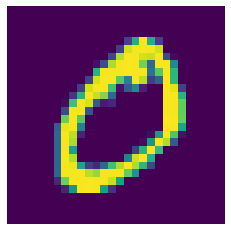

array([0])

In [6]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

Show logs from message-dumper. The last cloud event should show a line like:

```JSON
"{\"data\": {\"feature_score\": null, \"instance_score\": null, \"is_adversarial\": [0]}, \"meta\": {\"name\": \"AdversarialVAE\", \"detector_type\": \"offline\", \"data_type\": null}}"
```

This shows the last event was not an adversarial attack.

In [ ]:
!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container

## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [ ]:
from alibi_detect.utils.saving import  load_tf_model
filepath = './model_mnist/'
model = load_tf_model(filepath)

In [ ]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Select observations for which we will create adversarial instances:

In [ ]:
ids = np.arange(5)
X_to_adv = X_test[ids]
print(X_to_adv.shape)

Launch adversarial attack. Follow the [Basic Iterative Method (Kurakin et al. 2016)](https://arxiv.org/pdf/1607.02533.pdf) when `rand_init` is set to 0 or the [Madry et al. (2017)](https://arxiv.org/pdf/1706.06083.pdf) method when `rand_minmax` is larger than 0:

In [ ]:
# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent
X_adv = projected_gradient_descent(model_logits,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

In [ ]:
y_pred = predict(X_to_adv)
y_pred_adv = predict(X_adv)

We can look at the logs of the message dumper and see the last 2 cloud events which should show the results of outr batch prediction of ordinary examples and our modifed adversarial attacks:

```JSON
"{\"data\": {\"feature_score\": null, \"instance_score\": null, \"is_adversarial\": [0, 0, 0, 0, 0]}, \"meta\": {\"name\": \"AdversarialVAE\", \"detector_type\": \"offline\", \"data_type\": null}}"
```

and 

```JSON
"{\"data\": {\"feature_score\": null, \"instance_score\": null, \"is_adversarial\": [1, 1, 1, 1, 1]}, \"meta\": {\"name\": \"AdversarialVAE\", \"detector_type\": \"offline\", \"data_type\": null}}"
```

This shows the first batch of 5 were not adversarial but the second 5 were:

  * `is_adversarial: [0, 0, 0, 0, 0]`
  * `is_adversarial: [1, 1, 1, 1, 1]`

In [ ]:
!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container

In [ ]:
n_rows = X_to_adv.shape[0]
n_cols = 2
figsize = (10, 20)
img_shape = (28, 28)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

n_subplot = 1
for i in range(n_rows):
    plt.subplot(n_rows, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Original'
                  '\nPred: {}'.format(y_pred[i]))
    else:
        plt.title('Pred: {}'.format(y_pred[i]))
    plt.imshow(X_to_adv[i].reshape(img_shape))
    n_subplot += 1

    plt.subplot(n_rows, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial'
                  '\nPred: {}'.format(y_pred_adv[i]))
    else:
        plt.title('Pred: {}'.format(y_pred_adv[i]))
    plt.imshow(X_adv[i].reshape(img_shape))
    n_subplot += 1
plt.show()

## Get Adversarial Scores

We call the adversarial detector directly to get instance scores.


In [ ]:
from alibi_detect.utils.visualize import plot_instance_score
X = np.concatenate([X_to_adv, X_adv], axis=0)
ad_preds = detect(X)
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X.shape[0])])
plot_instance_score(ad_preds, target, labels, 0.5)